In [1]:
import sys
sys.path.append('..')
import edlib
import numpy as np
from collections import Counter, defaultdict
import operator
from string import ascii_uppercase


from lrd_parser import LRD_Report
from utils.bio import hamming_distance, identity_shift, OverlapAlignment, compress_homopolymer
import networkx as nx

import matplotlib
%matplotlib inline 
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from ndex2.nice_cx_network import NiceCXNetwork
import ndex2.client as nc
import ndex2

%load_ext autoreload
%autoreload 2

# Ref unique k-mers

In [2]:
man_assembly_fn = "/Poppy/abzikadze/centroFlye/centroFlye_repo/data/D6Z1/CEN6_ManVERSION3.tsv"

units = []
with open(man_assembly_fn) as f:
    for line in f:
        line = line.strip().split('\t')
        st, en = int(line[-2]), int(line[-1])
        if en < 17:
            en -= 1
        units.append((st, en))
        
def units2monomers(units):
    monomers = []
    for (s, e) in units:
        monomers.append(ascii_uppercase[s:e+1])
    monomers = ''.join(monomers)
    return monomers

ref_monomers = units2monomers(units)

k = 200
ref_kmers = [ref_monomers[i:i+k] for i in range(len(ref_monomers) - k + 1)]

ref_kmers = Counter(ref_kmers)
set_ref_kmers = set(ref_kmers.keys())
ref_unique_kmers = set(kmer for kmer, cnt in ref_kmers.items() if cnt == 1)

In [3]:
len(ref_unique_kmers)

8802

In [4]:
def get_kmer_pos(string, k):
    pos = defaultdict(list)
    for i in range(len(string)-k+1):
        pos[string[i:i+k]].append(i)
    return pos

ref_pos = get_kmer_pos(string=ref_monomers, k=k)

# Recruitment of unique k-mers

In [5]:
lrd_report_fn = '/Poppy/abzikadze/centroFlye/centroFlye_repo/experiments/20191023/lrd_d6z1_rel3_Karen/decomposition.tsv'
monomers_fn = "/Poppy/abzikadze/tandem_flye/data/human/isolated_centromeres/extracted_HORs/CEN6/monomers/inferred_monomers_single.fa"

lrd_report = LRD_Report(lrd_report_fn=lrd_report_fn, monomers_fn=monomers_fn)

In [6]:
def get_rare_mono_kmers(lrd_report, k, min_mult, max_mult):
    all_kmers = Counter()
    kmer_locations = defaultdict(list)
    for r_id, record in lrd_report.records.items():
        string = record.string
        read_kmers = Counter()
        read_kmer_locations = defaultdict(list)
        for i in range(len(string)-k+1):
            kmer = string[i:i+k]
            if '=' not in kmer:
                read_kmers[kmer] += 1
                read_kmer_locations[kmer].append(i)
        for kmer, cnt in read_kmers.items():
            if cnt == 1:
                all_kmers[kmer] += 1
                kmer_locations[kmer].append((r_id, read_kmer_locations[kmer][0]))
                
    rare_kmers = {kmer: cnt for kmer, cnt in all_kmers.items()
                  if min_mult <= cnt <= max_mult}
    reads2rare_kmers = defaultdict(list)
    for kmer in rare_kmers:
        locs = kmer_locations[kmer]
        for loc in locs:
            r_id, coordinate = loc
            reads2rare_kmers[r_id].append(coordinate)
    for r_id in reads2rare_kmers:
        reads2rare_kmers[r_id].sort()
    return rare_kmers, reads2rare_kmers, all_kmers


In [7]:
rare_min_mult, rare_max_mult = 5, 15

rare_kmers, reads2rare_kmers, all_read_kmers = \
    get_rare_mono_kmers(lrd_report, k=k, min_mult=rare_min_mult, max_mult=rare_max_mult)

unique reference {{k}}-mers not present in reads

In [8]:
sum(all_read_kmers[kmer] == 0 for kmer in ref_unique_kmers)

2687

In [24]:
uniqueRef_absentReads_pos = [ref_pos[kmer] for kmer in ref_unique_kmers if all_read_kmers[kmer] == 0]
uniqueRef_absentReads_pos = sorted(sum(uniqueRef_absentReads_pos, []))

<BarContainer object of 2687 artists>

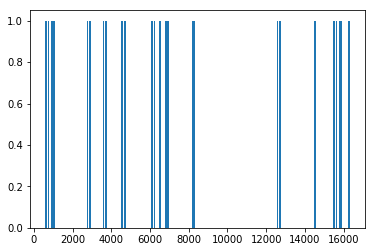

In [25]:
plt.bar(uniqueRef_absentReads_pos, height=1)

In [9]:
set_rare_kmers = set(rare_kmers.keys())
len(ref_unique_kmers), len(set_rare_kmers & ref_unique_kmers), len(set_rare_kmers - set_ref_kmers), len(set_rare_kmers)

(8802, 4099, 2369, 6634)

Need to create a plot of dependency of everything depending on parameters

In [10]:
def get_dist_graph(lrd_report, reads2rare_kmers, k):
    dist_graph = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))
    for r_id, coords in reads2rare_kmers.items():
        print(r_id)
        seq = lrd_report.records[r_id].string
        for c1 in coords:
            for c2 in coords:
                kmer1 = seq[c1:c1+k]
                kmer2 = seq[c2:c2+k]
                dist_graph[kmer1][kmer2][c2-c1] += 1
    return dist_graph

In [11]:
dist_graph = get_dist_graph(lrd_report=lrd_report,
                            reads2rare_kmers=reads2rare_kmers,
                            k=k)

00739941-c14c-40bd-9fad-fabff753795b
35e23dc0-4219-4951-b491-be041f325bf3
42affd5a-e784-44ae-8899-d978b5a8ee10
6e54ff5e-7a55-4dad-bae3-004d255dddbd
7e9301cd-6184-44f7-9db4-849ac08d33a5
8e85dd90-8045-4df1-ba7b-b6b576deaa4d
9f11e0b2-3f1f-46b0-bcfb-72fd5eaff950
a7a6eb6b-2225-4396-bb6b-2c0809993922
ab79a298-1f1a-44da-a174-6a52ae8abfcd
ca0eeaaf-2aee-4e3e-9134-acca35d636ad
db403540-296f-4a52-b04b-489c9f8116ef
f93d3935-7068-41ed-84ad-7b53b5460df5
8f633f5b-eb70-4ab0-94d2-77c708561492
e1e9d70e-c20b-47fe-89b3-8777b85ccc43
df9e6b8f-e94b-4bac-a69e-9e98b1769c42
df436222-50d1-4975-861e-58ab06750067
c0e1dce1-3466-415a-bde7-a6e371a3db86
871dbdd1-62eb-4c4b-b2fa-000febf9ba16
31700b15-5b3d-4d8c-b047-7836cb183613
42da64e4-e647-4426-b497-cda32cd3ca28
5da9ab31-d608-4581-b5fd-37acce77300e
ea920754-ed98-43fc-aab4-10bc923ba16e
747e0d59-fbd1-4378-bc82-77287e4bc114
e271f539-e586-4ca0-b153-01c72400eaa3
01f80610-395e-4ef8-93d0-526989b8cb53
079aa8c8-90a4-4fe8-af37-d9170f7d82b7
794fcdf4-9216-42c1-abf6-e151c28caa2b
8

e300ffe2-45b9-4858-82cf-aedf292f9191
ea8138e6-df5a-4f84-aff5-5d1cb8ca5ed1
ee709491-ebdf-4e40-b4ab-4f79c3f39ec2
efca4ba3-97ea-4f08-bfc9-a6f043685167
faaa25a5-d105-4e2f-80c0-c79c0f3bea3d
31b10227-6059-4013-a693-6254726fab55
88736f6e-176d-4f3e-b044-8c9f5003ac56
182f1138-55b1-45dc-8230-e052f3aa6a44
0b1f944b-90f7-4e17-a1cd-f02d38d0f84c
44d4d9b7-8566-446a-b6aa-0811c2eec0b3
a5bfccd4-6695-42aa-aba2-6d4b2ca248b4
e5f8222d-2fca-40b9-8c6c-20c95bf7d6ec
fd270d3b-2470-4c28-b84c-4dfa2ca4edaa
0b928976-0529-4907-b3a4-d15847c31fb5
4baab0ec-f951-4fdd-8b47-ecc7f3fef697
9d4b84dd-97d1-42b0-9748-59175ea6072d
0c50866b-f780-4551-a4bb-aa35a72f3f4d
17abf8ff-b793-474c-a260-9284ae6d23e2
a417181c-d65d-4c58-800b-f9be5fb7a5f8
dccab6e2-af28-4920-adc4-46518380d7ba
f075b1be-4eee-4356-bf09-4377e2a98ea1
44881201-9746-4ce0-9a88-b6d3b97045af
11f3f86e-7a31-466c-a78e-f2d96995b70c
6cab947f-d34f-4290-a06f-56de0f833f5b
6cc9540d-e509-4846-8483-756bdaec3fce
7bc276f0-1b37-442c-83b8-ba0f8cba3770
97d968c4-3f16-4c6e-acb2-f79f092e9ab3
e

In [12]:
def get_unique_mono_kmers(dist_graph, min_coverage, min_dist, threshold=0.8):
    unique_kmers = set()
    for kmer1 in dist_graph:
        for kmer2 in dist_graph[kmer1]:
            freqs = dist_graph[kmer1][kmer2]
            argmax_freq, max_freq = None, 0
            for dist, freq in freqs.items():
                if freq > max_freq:
                    max_freq = freq
                    argmax_freq = dist
            if argmax_freq < min_dist:
                continue
            sum_freq = sum(freqs.values())
            # if len(freqs) > 1:
            #    print(freqs.values())
            if sum_freq >= min_coverage and max_freq / sum_freq >= threshold:
                unique_kmers.add(kmer1)
                unique_kmers.add(kmer2)
    return unique_kmers

In [13]:
unique_kmers = get_unique_mono_kmers(dist_graph, min_coverage=5, min_dist=k)

In [14]:
len(unique_kmers)

5025

In [15]:
len(rare_kmers)

6634

In [16]:
len(ref_unique_kmers), len(unique_kmers & ref_unique_kmers), len(unique_kmers - set_ref_kmers), len(unique_kmers)

(8802, 3321, 1573, 5025)

<BarContainer object of 3 artists>

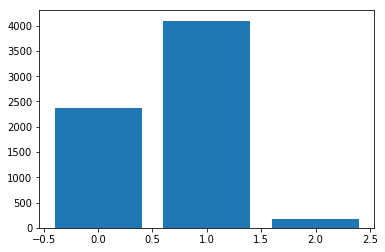

In [17]:
ref_freq_unique_kmers = {kmer: ref_kmers[kmer] for kmer in rare_kmers}
ref_freq_unique_kmers_cnt = Counter(ref_freq_unique_kmers.values())
plt.bar(ref_freq_unique_kmers_cnt.keys(), height = ref_freq_unique_kmers_cnt.values())

In [18]:
ref_freq_unique_kmers_cnt

Counter({0: 2369, 1: 4099, 2: 166})

<BarContainer object of 3 artists>

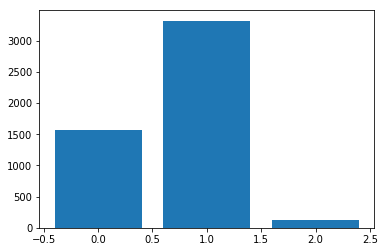

In [19]:
ref_freq_unique_kmers = {kmer: ref_kmers[kmer] for kmer in unique_kmers}
ref_freq_unique_kmers_cnt = Counter(ref_freq_unique_kmers.values())
plt.bar(ref_freq_unique_kmers_cnt.keys(), height = ref_freq_unique_kmers_cnt.values())

In [20]:
ref_freq_unique_kmers_cnt

Counter({0: 1573, 1: 3321, 2: 131})

In [21]:
repetitive_pos = [ref_pos[kmer] for kmer in rare_kmers if ref_kmers[kmer] > 1]
repetitive_pos = sorted(sum(repetitive_pos, []))

<BarContainer object of 332 artists>

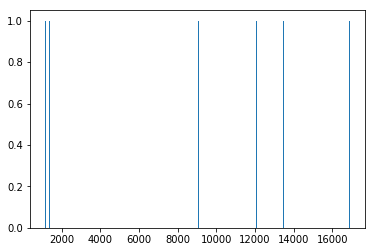

In [22]:
plt.bar(repetitive_pos, height=1)

In [23]:
repetitive_pos

[1162,
 1163,
 1164,
 1165,
 1166,
 1167,
 1168,
 1169,
 1170,
 1171,
 1172,
 1173,
 1174,
 1175,
 1176,
 1177,
 1178,
 1179,
 1180,
 1181,
 1182,
 1183,
 1184,
 1185,
 1186,
 1187,
 1188,
 1189,
 1190,
 1191,
 1192,
 1193,
 1194,
 1195,
 1196,
 1197,
 1198,
 1199,
 1200,
 1201,
 1202,
 1203,
 1204,
 1205,
 1206,
 1207,
 1208,
 1209,
 1210,
 1211,
 1212,
 1213,
 1214,
 1354,
 1355,
 1356,
 1357,
 1358,
 1359,
 1360,
 1361,
 1362,
 1363,
 1364,
 1365,
 1366,
 1367,
 1368,
 1369,
 1370,
 1371,
 1372,
 1373,
 1374,
 1375,
 1376,
 1377,
 1378,
 1379,
 1380,
 1381,
 1382,
 1383,
 1384,
 1385,
 1386,
 1387,
 1388,
 1389,
 1390,
 1391,
 1392,
 1393,
 1394,
 1395,
 1396,
 1397,
 1398,
 1399,
 1400,
 1401,
 1402,
 1403,
 1404,
 1405,
 1406,
 9083,
 9084,
 9085,
 9086,
 9087,
 9088,
 9089,
 9090,
 9091,
 9092,
 9093,
 9094,
 9095,
 9096,
 9097,
 9098,
 9099,
 9100,
 9101,
 9102,
 9103,
 9104,
 9105,
 9106,
 9107,
 9108,
 9109,
 9110,
 9111,
 9112,
 9113,
 9114,
 9115,
 9116,
 9117,
 9118,
 9119,